In [1]:
def is_running_in_colab():
    try:
        import google.colab
        !pip install nibabel nilearn dipy
        from google.colab import drive
        drive.mount('/content/drive')
        %pip install fslpy
        return True
    except ImportError:
        return False

In [2]:
%%capture
COLAB = is_running_in_colab()

In [3]:
import sys
import os
os.environ["DIPY_HOME"] = "./data/"
import dipy
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import subprocess
from copy import deepcopy

In [4]:
if not COLAB:
  from utils import loadFSL, FSLeyesServer, mkdir_no_exist
  fsleyesDisplay = FSLeyesServer()
  fsleyesDisplay.show()
  %gui wx

In [5]:
display = False

In [32]:
dataset_id = 'ds000171'
subject_id = 'control01'
sample_path = "/content/drive/MyDrive/NSSP/data/" if COLAB else "./data/"
os.makedirs(sample_path, exist_ok=True)
bids_root = op.join(sample_path, dataset_id)
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data')
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
flirt_path = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
fmaps = op.join(preproc_root, "sub-control01", "fmaps")
os.makedirs(fmaps, exist_ok=True)

In [7]:
target_path = f"{preproc_root}/sub-control01/func/sub-control01_task-music_concat_bold_moco_bbr_std_smoothed-6mm.nii.gz"

In [8]:
from nilearn.image import concat_imgs, mean_img
fmri_img = nib.load(target_path)

In [9]:
events_files = sorted([f for f in os.listdir(op.join(bids_root, 'sub-control01', 'func')) if f.endswith('.tsv') and "task-music" in f])
events_list = [pd.read_csv(op.join(bids_root, 'sub-control01', 'func', f), sep='\t') for f in events_files]
events = pd.concat(events_list, ignore_index=True)


In [10]:
onset = 0.0
for i,df in enumerate(events_list):
    df['onset'] = df['onset']+i*312


In [21]:
view = [-3,10,20]
fmri_args = {
    "noise_model":'ar1',
    "standardize":False,
    "hrf_model":'spm',
    "drift_model":None,
    "high_pass":.01,
    "n_jobs":-1,
    "verbose":2,
}

In [12]:
events = pd.concat(events_list, ignore_index=True)
events.tail()

,onset,duration,trial_type
49,864.0,3.0,response
50,867.0,31.5,positive_music
51,898.5,3.0,response
52,901.5,31.5,tones
53,933.0,3.0,response


In [13]:
# data = fmri_img.dataobj[...,:105*2]

# target_img = nib.Nifti1Image(data,fmri_img.affine, fmri_img.header)
# del fmri_img

In [17]:
import json

# Load JSON data from a file
with open(sample_path+"/task-music_bold.json", 'r') as file:
    data = json.load(file)

TR = data['RepetitionTime']

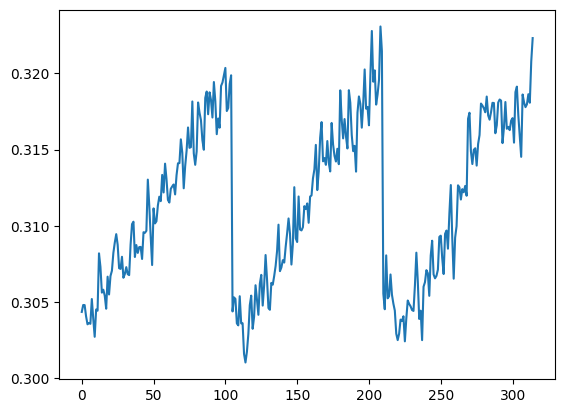

In [12]:
plt.plot(fmri_img.get_fdata().mean(axis=(0,1,2)))

In [22]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm1 = FirstLevelModel(t_r=TR,
                           **fmri_args
                           )

# Fit the model to our design and data
# fmri_glm = fmri_glm.fit(target_img, pd.concat(events_list[0:-1], ignore_index=True))
fmri_glm1 = fmri_glm1.fit(fmri_img, events)

Computing run 1 out of 1 runs (go take a coffee, a big one)
Masker took 52 seconds       
GLM took 56 seconds         

Computation of 1 runs done in 109.81407141685486 seconds.



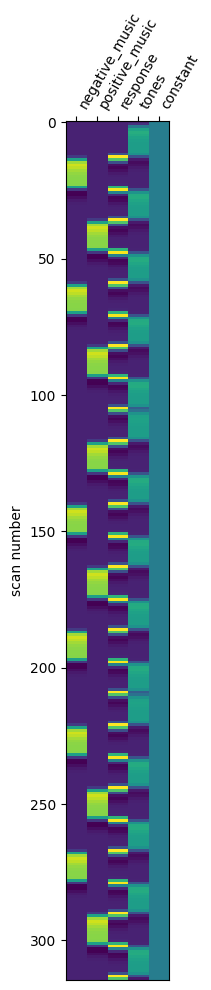

In [23]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm1.design_matrices_[0])
plt.show()

In [24]:
# Create the dictionary of the conditions
trial_type = ['positive_music', 'negative_music']

conditions = {
    trial_type[0]: np.array([0,1,0,0,0]),
    trial_type[1]:np.array([1,0,0,0,0])
}
positive_minus_negative = conditions[trial_type[0]] - conditions[trial_type[1]]

<Axes: label='conditions'>

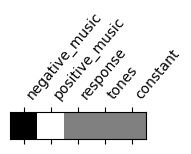

In [25]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(positive_minus_negative, design_matrix=fmri_glm1.design_matrices_[0])  ####TODO ADD COLOR SCALE

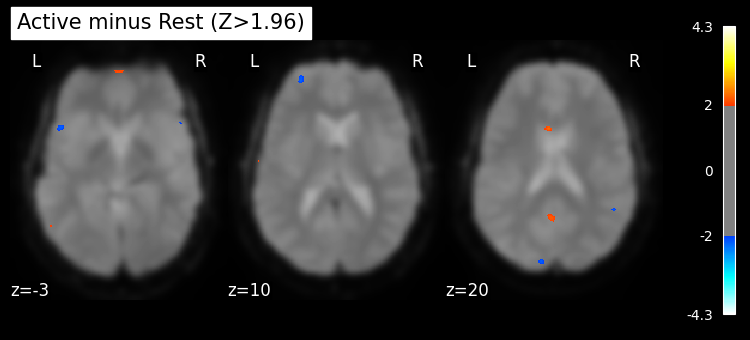

In [34]:
import nibabel as nib
z_map = fmri_glm1.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, op.join(fmaps,'z_map_uncorrected_v0.nii.gz'))
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
threshold = 1.96
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=view, black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

In [35]:
from nilearn.glm.first_level.design_matrix import _make_drift

column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.arange(0, fmri_img.dataobj.shape[-1])*int(TR), order=3, high_pass=None)

In [60]:
design_mat = fmri_glm1.design_matrices_[0].copy()
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

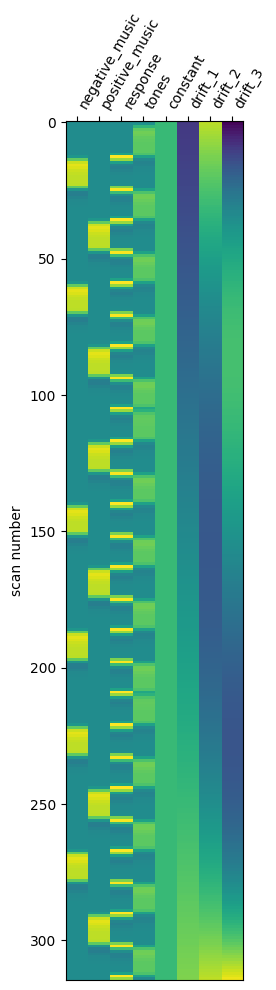

In [61]:
plot_design_matrix(design_mat)
plt.show()

<Axes: label='conditions'>

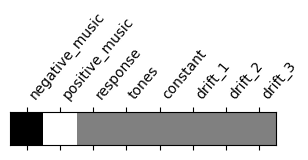

In [65]:
from nilearn.plotting import plot_contrast_matrix
conditions = {
    trial_type[0]: np.array([0,1,0,0,0,0,0,0]),
    trial_type[1]:np.array([1,0,0,0,0,0,0,0])
}
positive_minus_negative = conditions[trial_type[0]] - conditions[trial_type[1]]
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat)

In [49]:
import nibabel as nib
fmri_glm2 = FirstLevelModel(t_r=TR, **fmri_args)
fmri_glm2.fit(fmri_img, design_matrices=[design_mat])



Computing run 1 out of 1 runs (go take a coffee, a big one)
Masker took 65 seconds       
GLM took 57 seconds         

Computation of 1 runs done in 123.72794961929321 seconds.



FirstLevelModel(drift_model=None, hrf_model='spm', n_jobs=-1, t_r=3.0,
                verbose=2)

In [64]:

z_map = fmri_glm2.compute_contrast(positive_minus_negative,
                                  output_type='z_score')
nib.save(z_map,op.join(fmaps,'z_map_uncorrected_v1.nii.gz'))

In [ ]:
import xml.etree.ElementTree as ET

def display_atlas_corresp(atlas_xml_path):
    """
    Given a path to an XML, extract all region labels and print their correspondance with numerical values
    of the nifti atlas file. (FSL-based convention)

    Parameters
    ----------
    atlas_xml_path: string
        Path to an XML atlas path, from which to extract all labels.
    """
    root=ET.parse(atlas_xml_path).getroot()
    for type_tag in root.findall('data/label'):
        value = type_tag.get('index')
        display('{} : {}'.format(int(value)+1, type_tag.text))

In [42]:
if display:
  fsleyesDisplay.resetOverlays()
  fsleyesDisplay.load(mni_template)
  fsleyesDisplay.load(flirt_path)
  fsleyesDisplay.load("z_map_uncorrected.nii.gz")
  fsleyesDisplay.load(op.expandvars('$FSLDIR/data/atlases/MNI/MNI-maxprob-thr25-1mm.nii.gz'))
  fsleyesDisplay.setOverlayCmap(3,'Render3')
  display_atlas_corresp(op.expandvars('$FSLDIR/data/atlases/MNI.xml'))

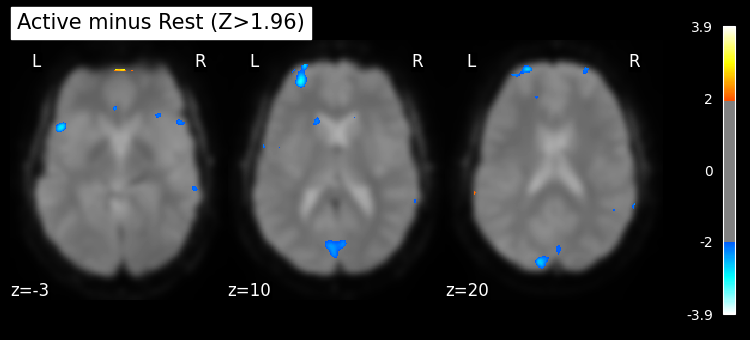

In [66]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
threshold = 1.96
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=view, black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

inf


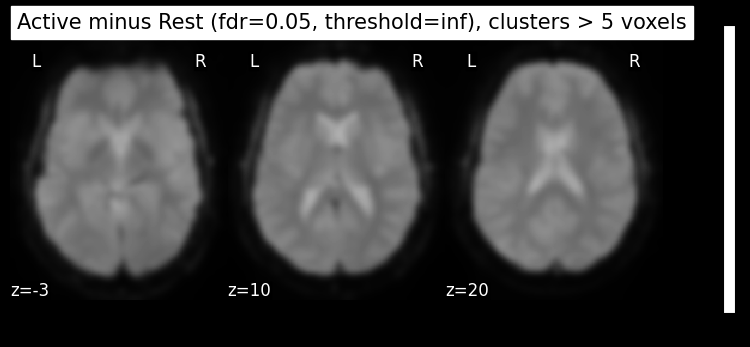

In [68]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 5 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
print(threshold)
# nib.save(clean_map, op.join(fmaps, f'cleaned_map_fdr{fdr_rate}_cluster{cluster_size}.nii.gz'))
# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=view, black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()

In [70]:
design_mat = fmri_glm2.design_matrices_[0].copy()
for i in range(3):
    indicator = np.zeros(fmri_img.dataobj.shape[-1])
    indicator[i*105:(i+1)*105] = 1
    design_mat[f"run_{i}"] = indicator

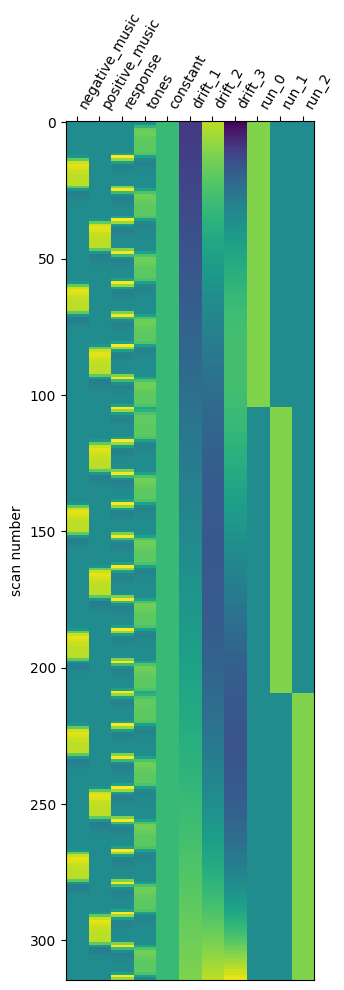

In [71]:
plot_design_matrix(design_mat)
plt.show()

<Axes: label='conditions'>

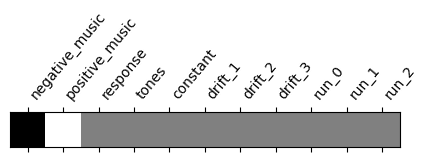

In [72]:
# Create the dictionary of the conditions
trial_type = ['positive_music', 'negative_music']

conditions = {
    trial_type[0]: np.array([0,1,0,0,0,0,0,0,0,0,0]),
    trial_type[1]:np.array([1,0,0,0,0,0,0,0,0,0,0])
}
positive_minus_negative = conditions[trial_type[0]] - conditions[trial_type[1]]
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat)

In [57]:
import nibabel as nib
fmri_glm3 = FirstLevelModel(t_r=TR,**fmri_args)
fmri_glm3.fit(fmri_img, design_matrices=[design_mat])


Computing run 1 out of 1 runs (go take a coffee, a big one)
Masker took 53 seconds       
GLM took 54 seconds         

Computation of 1 runs done in 109.14380431175232 seconds.



FirstLevelModel(drift_model=None, hrf_model='spm', n_jobs=-1, t_r=3.0,
                verbose=2)

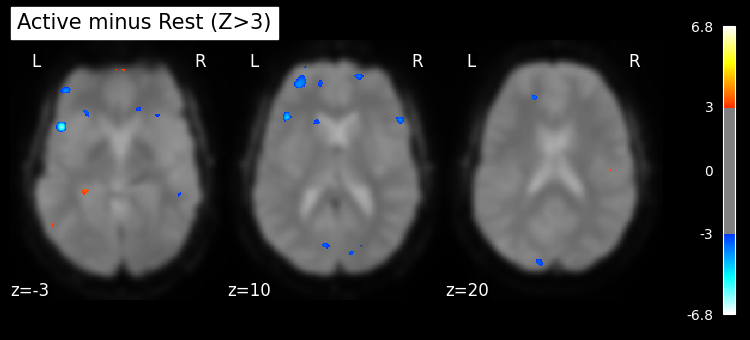

In [73]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
z_map = fmri_glm3.compute_contrast(positive_minus_negative,
                                  output_type='z_score')
nib.save(z_map, op.join(fmaps,'z_map_uncorrected_v2.nii.gz'))
mean_img_ = mean_img(fmri_img),
threshold = 3
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=view, black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

4.097863721928175


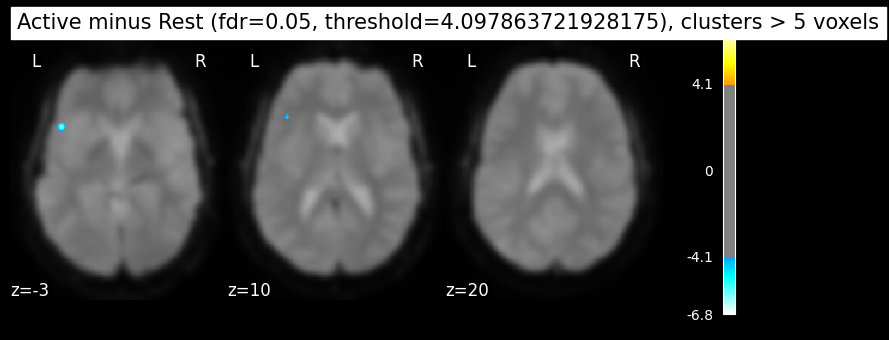

In [59]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 5 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
print(threshold)
nib.save(clean_map, op.join(fmaps, f'cleaned_map_fdr{fdr_rate}_cluster{cluster_size}.nii.gz'))
# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=view, black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()